# Time Series Forecasting with LSTM Using PyTorch

Based on the tutorial by [Saripudin](https://github.com/spdin).

This notebook uses LSTM to predict shampoo sales. The data used describes the monthly number of sales of shampoo over a 3-year period. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

You can uncomment the first line under "Data Plot" and run the same tutorial to instead predict the number of international airline passengers, given a certain year and a month.

## Install libraries

In [1]:
# !pip install pandas

## Library

In [2]:
import datetime as dt
import math 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM




## Getting Raw Data

In [3]:
raw_data = pd.read_csv("owid-covid-data.csv")
country_data = raw_data.loc[raw_data["location"] == "Singapore"]

#show condensed info on all variables
country_data.info()

#changing indexes to dates instead of numbers
country_data.set_index(pd.to_datetime(country_data["date"],format = "%Y-%m-%d"), inplace = True)
country_data = country_data.drop(["date"],axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 124112 to 124831
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    720 non-null    object 
 1   continent                                   720 non-null    object 
 2   location                                    720 non-null    object 
 3   date                                        720 non-null    object 
 4   total_cases                                 720 non-null    float64
 5   new_cases                                   720 non-null    float64
 6   new_cases_smoothed                          715 non-null    float64
 7   total_deaths                                662 non-null    float64
 8   new_deaths                                  662 non-null    float64
 9   new_deaths_smoothed                         662 non-null    float64
 10  total_

## Data Analysis (Picking variables) 

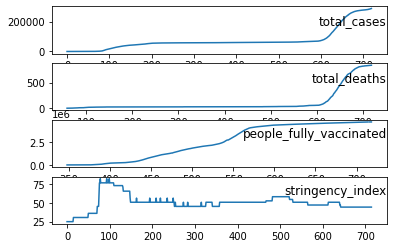

In [4]:

#selecting important variables
chosen_variables = ["total_cases","total_deaths","people_fully_vaccinated","stringency_index",]#,"total_boosters", "people_vaccinated",
#seven day runnging average smoothing is accurate
data = country_data[chosen_variables]

# plotting graphs
groups = range(len(chosen_variables))
i = 1
data_values = data.values

plt.figure() 
for group in groups: # plot each column
    plt.subplot(len(groups), 1, i)
    plt.plot(data_values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

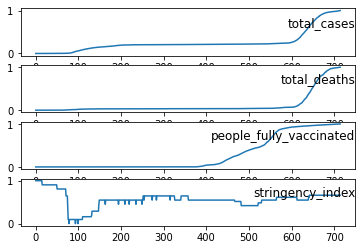

In [15]:
data = country_data[chosen_variables]

#displays whole datframe to check for any errors
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(data)

#removing incomplete data 
# start = dt.datetime.strptime('2020-02-23 00:00:00', '%Y-%m-%d %H:%M:%S')
# end = dt.datetime.strptime('2020-9-06 00:00:00', '%Y-%m-%d %H:%M:%S')
start = dt.datetime.strptime('2020-01-23 00:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2022-1-06 00:00:00', '%Y-%m-%d %H:%M:%S')
data = data.loc[(data.index >= start) & (data.index <= end)]

#converting NaN to 0.
data.fillna(0, inplace=True)

#inverting stringency
data["stringency_index"] = 100 - data["stringency_index"]

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

groups = range(len(chosen_variables))
i = 1

plt.figure() 
for group in groups: # plot each column
    plt.subplot(len(groups), 1, i)
    plt.plot(scaled_data[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Dataloading

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = data.values
# ensure all data is float
values = values.astype('float32')

save_values = values#this is kinda just due to bad coding practices lol

scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed)
 
# split into train and test sets
values = reframed.values
n_train_days = int(len(values) * 0.67) #basically train size
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1     0.000000   0.000000   0.000000   1.000000  0.000007
2     0.000007   0.000000   0.000000   1.000000  0.000007
3     0.000007   0.000000   0.000000   1.000000  0.000011
4     0.000011   0.000000   0.000000   1.000000  0.000014
5     0.000014   0.000000   0.000000   1.000000  0.000021
..         ...        ...        ...        ...       ...
710   0.988161   0.992814   0.998025   0.661383  0.989676
711   0.989676   0.992814   0.998310   0.661383  0.991314
712   0.991314   0.992814   0.998806   0.661383  0.994287
713   0.994287   0.996407   0.999246   0.661383  0.997129
714   0.997129   0.998802   0.999626   0.661383  1.000000

[714 rows x 5 columns]
(478, 1, 4) (478,) (236, 1, 4) (236,)


## Model

In [17]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

## Training

(236, 1, 4)
(236, 1) (236, 4)


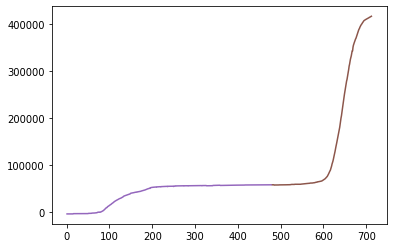

In [30]:
# fit network
print(test_X.shape)
# history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

look_back = 1
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
# invert prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
print(testPredict.shape,test_X.shape)
testPredict = np.concatenate((testPredict, test_X[:, 1:]), axis=1)
testPredict = scaler.inverse_transform(testPredict)
testPredict = testPredict[:,0]
# invert scaling for actual
trainPredict = trainPredict.reshape((len(trainPredict), 1))
trainPredict = np.concatenate((trainPredict, train_X[:, 1:]), axis=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = trainPredict[:,0]
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(test_y[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(values[:,1])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:]
# shift test predictions for plotting
testPredictPlot = np.empty_like(values[:,1])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:-1] = testPredict[:-4]
# plot baseline and predictions
realgraph = scaler.inverse_transform(values[:,:-1])


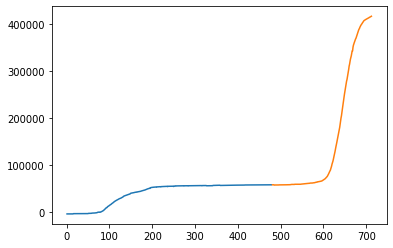

In [32]:

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# print(values)

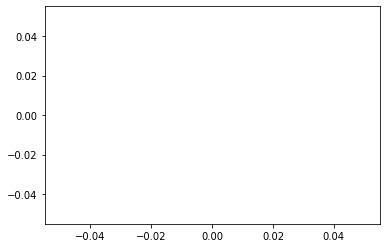

In [35]:
prin